In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

In [15]:
df = pd.read_csv('C:/Files/sales_data.csv')

Making an id column to keep the original sorting.

In [17]:
df['id_temp'] = range(1, len(df)+1)

Re arranging the columns to find some correlations.

In [18]:
df = df[['ORDERNUMBER', 'PRODUCTCODE', 'MSRP', 'PRICEEACH',  'QUANTITYORDERED',  'SALES', 'ORDERLINENUMBER', 'PRODUCTLINE',
 'STATUS', 'CUSTOMERNAME', 'QTR_ID', 'MONTH_ID', 'YEAR_ID','ORDERDATE', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY',
 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE', 'id_temp']]

In [19]:
df_pricings = df['STATLA

Making a total orders column for each order to compare by each one

In [20]:
total_order = df.groupby(['ORDERNUMBER'])['ORDERLINENUMBER'].count().reset_index()[['ORDERNUMBER', 'ORDERLINENUMBER' ]]
total_order.rename(columns={'ORDERLINENUMBER' : 'TOTALORDER'})
df = pd.merge(df, total_order, on='ORDERNUMBER').sort_values(by='id_temp').reset_index(drop=True)

Some orders had delivery charges. Getting a profit per unit and total profit for the stores who buy from the company to get an idea of how much they can make.

In [21]:
df['DELIVERY'] = df['SALES'] - (df['PRICEEACH'] *df['QUANTITYORDERED'])
df['SALES_WITHOUT_DELIVERY'] = df['PRICEEACH'] *df['QUANTITYORDERED']
df['PROFIT_POTENTIAL_EACH'] = df['MSRP'] - df['PRICEEACH']
df['PROFIT_POTENTIAL_TOTAL'] = (df['MSRP'] - df['PRICEEACH']) * df['QUANTITYORDERED']
df['MSRP_TOTAL'] = (df['MSRP'] * df['QUANTITYORDERED']).round(2)
df['MSRP-PRICEEACH'] = (df['MSRP_TOTAL']- df['SALES']).round(2)

Getting the most sold product categories

In [23]:
df.groupby(['PRODUCTLINE'])['id_temp'].count().sort_values(ascending=False)

PRODUCTLINE
Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: id_temp, dtype: int64

Top cities of each product type

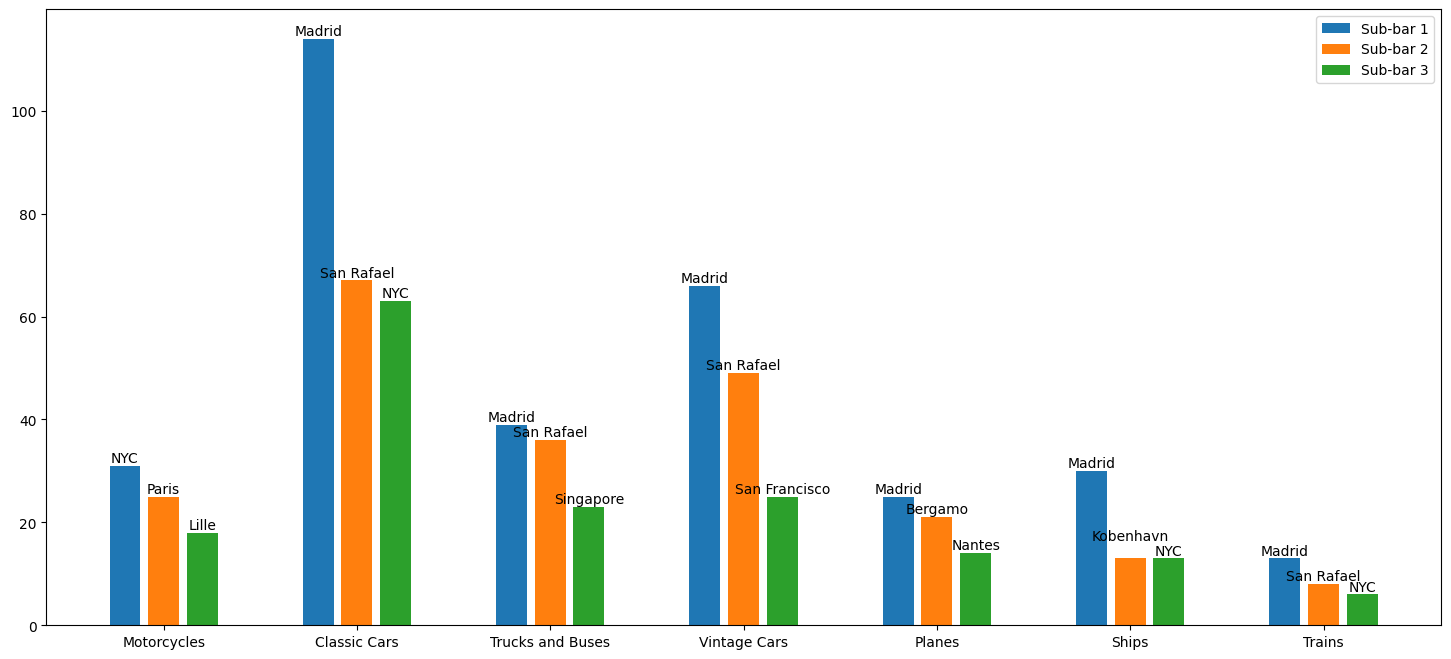

In [24]:
import random

counts_list = []
countries_list = []
categories = df['PRODUCTLINE'].unique().tolist()
for product in categories:
    filter = df['PRODUCTLINE'] == product
    top = df.loc[filter].groupby([ 'PRODUCTLINE', 'CITY'])['id_temp'].count().nlargest(3).reset_index()
    counts_list.append(top['id_temp'])
    countries_list.append(top['CITY'])

data = np.array(counts_list).T
countries = np.array(countries_list).T
width = 0.2

fig, ax = plt.subplots(figsize=(18,8))

for i in range(data.shape[0]):
    x_positions = np.arange(len(categories)) + i * width
    ax.bar(x_positions, data[i], width=width - 0.04, label=f'Sub-bar {i + 1}')


    for j, (datum, country) in enumerate(zip(data[i], countries[i])):
       
        if  str(country) == 'Kobenhavn':
            
            ax.text(x_positions[j], datum + 3, str(country) , ha='center', va='bottom')
        else:
            ax.text(x_positions[j] , datum + 0.1  , str(country), ha='center', va='bottom')

ax.set_xticks(np.arange(len(categories)) + (data.shape[0] - 1) * width / 2)
ax.set_xticklabels(categories)
ax.legend()
plt.show()


Looking at the compositions of the top 3 cities each product type was sold. Madrid looks like a good place to sell a number of products

The best and worst 5 customers on the company's side. Here the only metric available was the difference between MSRP and price. So the lower the difference the more profit the company would make. I had to scale the graph also to show the comparison. 
The customers who gave the company the most profit also were buy a lot lower quantities than the customers who GOT the most profit. So that is also one area to be considered.

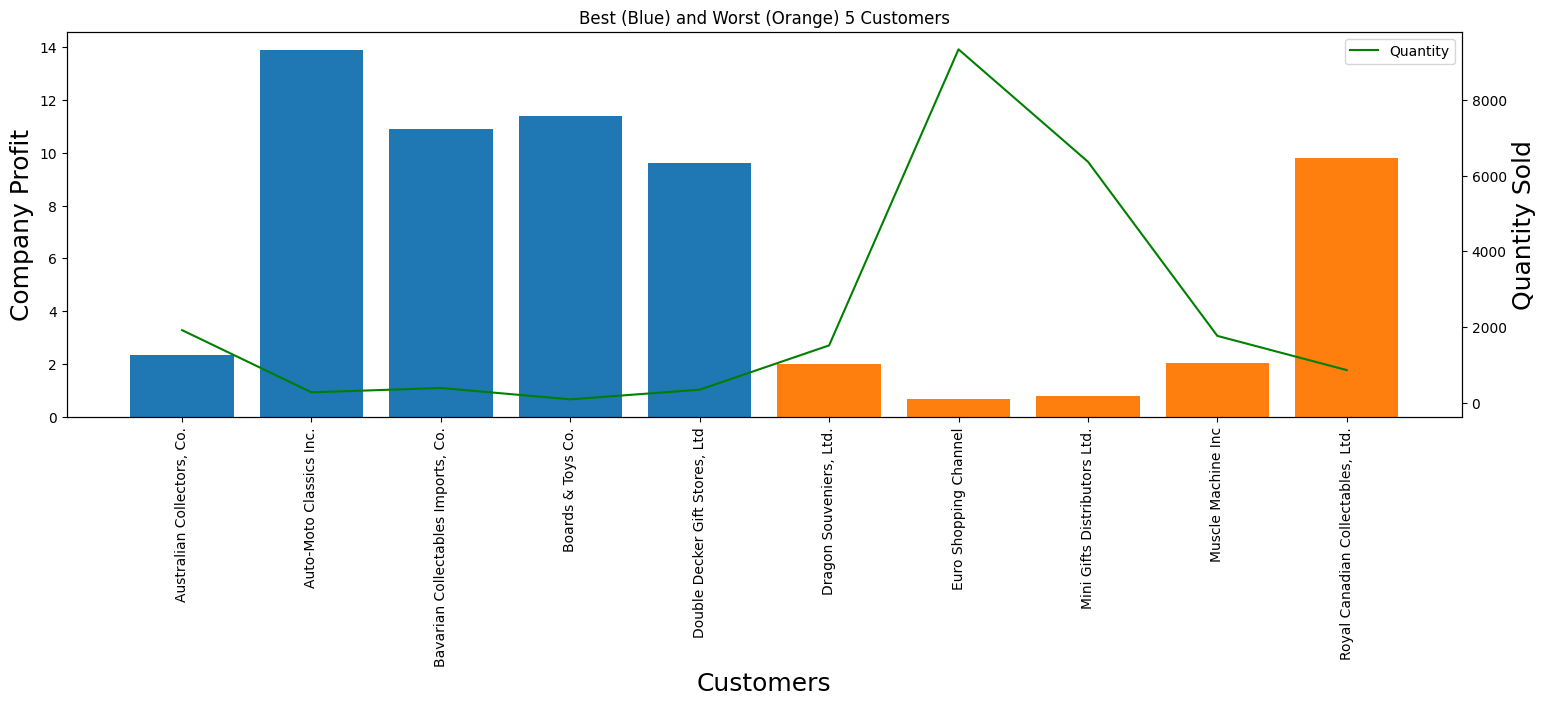

In [103]:
def scaler(x):
    return 100000 /( x  + 8000)



best_customers = df.groupby(['CUSTOMERNAME'])['PROFIT_POTENTIAL_TOTAL'].sum().sort_values().head(5)

worst_customers = df.groupby(['CUSTOMERNAME'])['PROFIT_POTENTIAL_TOTAL'].sum().sort_values().tail(5)

customers = pd.concat([best_customers,worst_customers]).sort_index()

filter = df['CUSTOMERNAME'].isin(customers.index)
best_customers_quantity = df.loc[filter].groupby(['CUSTOMERNAME'])['QUANTITYORDERED'].sum().sort_values().head(5)

worst_customer_quantity = df.loc[filter].groupby(['CUSTOMERNAME'])['QUANTITYORDERED'].sum().sort_values().tail(5)

customers_quantity = pd.concat([best_customers_quantity,worst_customer_quantity]).sort_index().reset_index()
customers = customers.apply(scaler).reset_index()


fig, ax1 = plt.subplots(figsize=(18,5))
font = '18'
ax2 = ax1.twinx()
ax2.plot(customers_quantity.iloc[:,0], customers_quantity.iloc[:,1], color='g', label = 'Quantity')

ax1.bar(customers.iloc[:5,0], customers.iloc[:5,1], )
ax1.bar(customers.iloc[5:,0], customers.iloc[5:,1], )
ax1.set_xticks(customers.iloc[:,0])
ax1.set_xticklabels(customers.iloc[:,0], rotation='vertical')
plt.title('Best (Blue) and Worst (Orange) 5 Customers')
ax1.set_xlabel('Customers', fontsize  = font)
ax1.set_ylabel('Company Profit', fontsize = font)
ax2.set_ylabel('Quantity Sold', fontsize  = font)
plt.legend()


plt.show()


The products that made the company the most money are given here. I used the same metric as before In this case also.

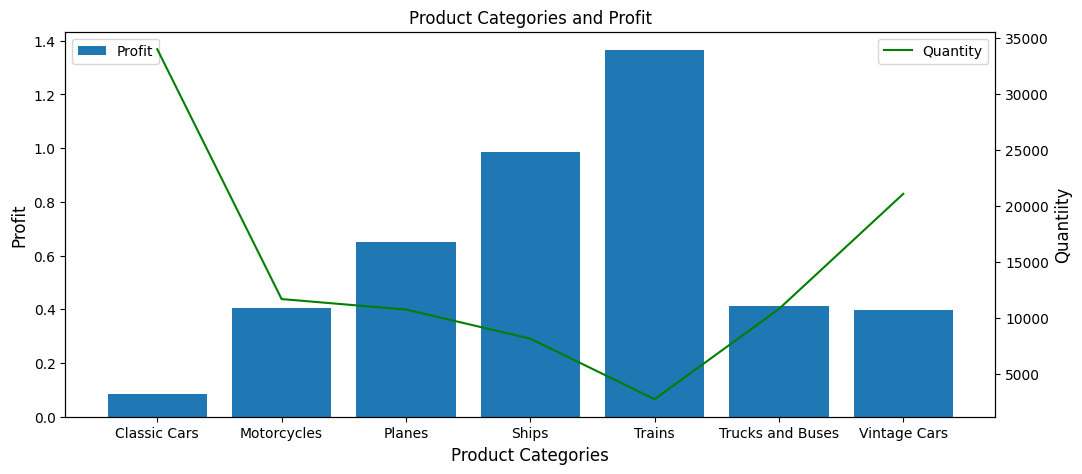

In [135]:
def scaler(x):
    return 100000 /( x  + 80000)
products_group = df.groupby(['PRODUCTLINE'])
products_profitable = products_group['PROFIT_POTENTIAL_TOTAL'].sum().reset_index()
products_profitable['PROFIT_POTENTIAL_TOTAL'] = products_profitable['PROFIT_POTENTIAL_TOTAL'].apply(scaler)
size = '12'
products_quantity = products_group['QUANTITYORDERED'].sum().reset_index()
fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
ax2.plot(products_quantity.iloc[:,0], products_quantity.iloc[:,1], color ='g', label = 'Quantity')
plt.title('Product Categories and Profit')

ax1.bar(products_profitable.iloc[:,0], products_profitable.iloc[:,1], label = 'Profit')

ax1.set_ylabel('Profit', fontsize = size)
ax1.set_xlabel('Product Categories', fontsize = size)
ax2.set_ylabel('Quantiity', fontsize = size)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


Even though trains, planes and ships were sold at a very low quantity they still brought the company much greater profits than the rest so they are a good avenue for expansion.

The larger deals were given more discounts so the customers made more profit on them

In [31]:
df.groupby('DEALSIZE')['PROFIT_POTENTIAL_EACH'].mean().reset_index()

,DEALSIZE,PROFIT_POTENTIAL_EACH
0,Large,58.385159
1,Medium,20.487247
2,Small,8.292598


On the customer's side...

Most Profitable Customers

In [56]:
df.groupby(['CUSTOMERNAME', ])['PROFIT_POTENTIAL_TOTAL'].sum().sort_values(ascending=False).head(5)

CUSTOMERNAME
Euro Shopping Channel           142279.95
Mini Gifts Distributors Ltd.    121115.81
Dragon Souveniers, Ltd.          42316.05
Muscle Machine Inc               40599.96
Australian Collectors, Co.       34967.13
Name: PROFIT_POTENTIAL_TOTAL, dtype: float64

What they bought

In [66]:
top_customers = df.groupby(['CUSTOMERNAME', ])['PROFIT_POTENTIAL_TOTAL'].sum().sort_values(ascending=False).head(5).index
filt = df['CUSTOMERNAME'].isin(top_customers)
df[filt].groupby(['PRODUCTLINE'])['id_temp'].count()

PRODUCTLINE
Classic Cars        236
Motorcycles          42
Planes               38
Ships                37
Trains               27
Trucks and Buses     86
Vintage Cars        119
Name: id_temp, dtype: int64

The products that sold the most

In [80]:
least_sold = df.groupby([ 'PRODUCTCODE', 'PRODUCTLINE'])['SALES'].sum().sort_values(ascending=False).reset_index().head(8)
least_sold

,PRODUCTCODE,PRODUCTLINE,SALES
0,S18_3232,Classic Cars,288245.42
1,S10_1949,Classic Cars,191073.03
2,S10_4698,Motorcycles,170401.07
3,S12_1108,Classic Cars,168585.32
4,S18_2238,Classic Cars,154623.95
5,S12_3891,Classic Cars,145332.04
6,S24_3856,Classic Cars,140626.90
7,S12_2823,Motorcycles,140006.16


Which countries the company can get the most profit out of

In [138]:

countries = df.groupby(['COUNTRY'])['PROFIT_POTENTIAL_TOTAL'].mean().sort_values().head()
countries

COUNTRY
Canada       468.580857
Belgium      492.791515
UK           504.101806
Italy        524.744513
Australia    552.586703
Name: PROFIT_POTENTIAL_TOTAL, dtype: float64

What are sold most here?

In [142]:
filt = df['COUNTRY'].isin(countries.index)
df.loc[filt].groupby('PRODUCTLINE')['PROFIT_POTENTIAL_TOTAL'].sum()

PRODUCTLINE
Classic Cars        161836.36
Motorcycles          28346.32
Planes               20103.81
Ships                 9291.08
Trains                1471.72
Trucks and Buses     27126.62
Vintage Cars         35002.20
Name: PROFIT_POTENTIAL_TOTAL, dtype: float64

In [143]:
df['PROFIT_POTENTIAL_TOTAL']

0        -21.00
1        464.10
2         10.66
3        528.30
4       -245.00
         ...   
2818    -920.00
2819   -1334.00
2820   -1978.00
2821    -280.16
2822    -541.44
Name: PROFIT_POTENTIAL_TOTAL, Length: 2823, dtype: float64

In some cities a lot of purchases were made at a loss, making the company a lot of money.

In [42]:
filter = df_pricings['PRICEEACH'] < df_pricings['MSRP']
filter2 = df_pricings['PRICEEACH'] > df_pricings['MSRP']
x = pd.DataFrame()
y = pd.DataFrame()
x[['Country', 'City', 'Profit_Transactions']] = df_pricings.loc[filter].groupby(['COUNTRY'])['CITY'].value_counts().reset_index()
y[['Country', 'City', 'Loss_Transactions']]= df_pricings.loc[filter2].groupby(['COUNTRY'])['CITY'].value_counts().reset_index()
result = pd.merge(x, y, on=['City', 'Country'], how='outer')
result['Ratio'] = result['Profit_Transactions'] / result['Loss_Transactions']
result = result.sort_values(by='Ratio', ).head(5)
result

,Country,City,Profit_Transactions,Loss_Transactions,Ratio
28,Germany,Munich,5,9,0.555556
69,USA,Newark,11,10,1.100000
67,USA,Glendale,12,10,1.200000
47,UK,London,21,17,1.235294
16,Finland,Oulu,18,14,1.285714


Cities like Newark and Munich mad the company a lot of  money.

Text(0, 0.5, 'Quantity')

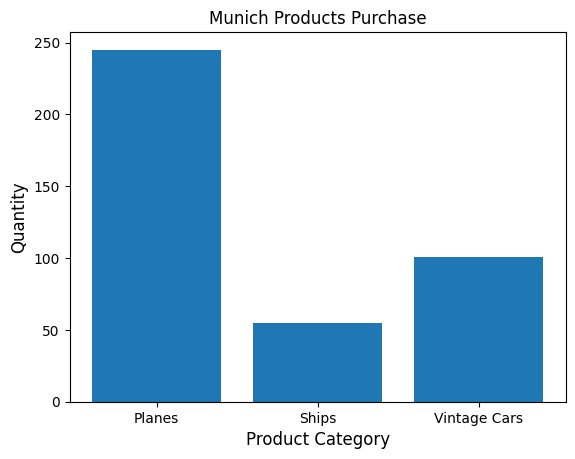

In [133]:
filt = df['CITY'] == 'Munich'
items = df.loc[filt].groupby(['PRODUCTLINE'])['QUANTITYORDERED'].sum().reset_index()

j= '12'
plt.bar(items.iloc[:,0], items.iloc[:,1])
plt.title('Munich Products Purchase')
plt.xlabel('Product Category', fontsize = j)
plt.ylabel('Quantity', fontsize = j)


Text(0, 0.5, 'Quantity')

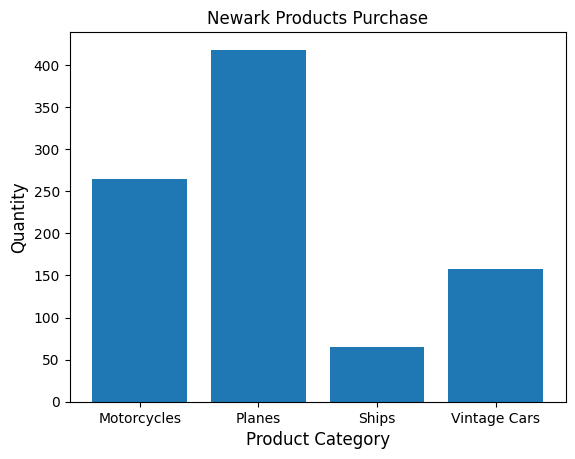

In [131]:
filt = df['CITY'] == 'Newark'
items = df.loc[filt].groupby(['PRODUCTLINE'])['QUANTITYORDERED'].sum().reset_index()

j= '12'
plt.bar(items.iloc[:,0], items.iloc[:,1])
plt.title('Newark Products Purchase')
plt.xlabel('Product Category', fontsize = j)
plt.ylabel('Quantity', fontsize = j)


Now when I check Newark and Munich I find they purchased a lot of planes and ships in such cities so it is a good place for the company to invest.